In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller
import lime
import lime.lime_tabular
import warnings
warnings.simplefilter('ignore')

In [17]:
df = pd.read_csv("../working_data/dataset.csv", index_col=0)

In [18]:
df = df[df["Category"] != "Industrial Crops"]

## Creating working data frame

In [19]:
#df['Year'] = pd.to_datetime(df['Year'], format='%Y')
#df.set_index("Year", inplace=True)
# getting list of names
categories = df["Category"].unique()

## Creating the metrics data frame

In [20]:
lime_df = pd.DataFrame()

## Gradient Boosting

### Setting up dataframe

#### - Solving for stationarity

In [21]:
imputer = KNNImputer(n_neighbors=4)
adf_df = pd.DataFrame(columns=df.columns)

for cate in categories: 
    # Selects category
    crop_df = df[df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    # Selects column for ADF Test
    for col in num_cols:
        if crop_df[col].count() < 5:
            continue
        adf_result = adfuller(crop_df[col])
        while adf_result[1] > 0.05:
            crop_df[col] = crop_df[col].diff()
            crop_df[num_cols.columns] = imputer.fit_transform(crop_df[num_cols.columns])
            adf_result = adfuller(crop_df[col])

    adf_df = pd.concat([adf_df, crop_df])

#### - Transforming time series data to supervised learning (adding lags to variables)

In [22]:
main_df = pd.DataFrame(columns=adf_df.columns)
imputer = KNNImputer(n_neighbors=4)

# Sliding Window
for cate in categories: 
    # Selects category
    crop_df = adf_df[adf_df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    for col in num_cols.columns:   
        for i in range(1, 3):
            crop_df[f'{col}-{i}'] = crop_df[col].shift(i)

    main_df = pd.concat([main_df, crop_df])
    num_cols = main_df.select_dtypes(include=[np.number])
    main_df[num_cols.columns] = imputer.fit_transform(main_df[num_cols.columns])

## Running the model

,Features Vegetables and Legumes,Coeffcients - Vegetables and Legumes
0,Summer <= 0.00,-35.861906
1,Mean CO2 (ppm) <= 0.00,13.743073
2,Mean CO2 (ppm)-2 <= 0.00,11.106422
3,Mean CO2 (ppm)-1 <= 0.00,8.834921
4,0.04 < Yield (tonnes/ha)-1 <= 0.20,6.614524
5,Year-Round <= 0.00,6.058118
6,Wind <= 0.49,4.860865
7,Devil-1 <= 0.00,-3.488811
8,Ice-2 > 0.00,3.433092
9,Tornado-2 <= 0.50,-3.414703


,Features Cereals,Coeffcients - Cereals
0,Mean CO2 (ppm)-2 <= 0.00,2.500212
1,Mean CO2 (ppm) <= 0.00,0.643117
2,Summer <= 0.00,-0.605513
3,Mean CO2 (ppm)-1 <= 0.00,-0.588511
4,Ice-1 <= 0.50,-0.487252
5,0.40 < Yield (tonnes/ha)-2 <= 0.54,0.422286
6,0.00 < Fall <= 1.00,0.418832
7,0.54 < Yield (tonnes/ha)-1 <= 0.66,0.359811
8,Precip-1 <= 0.48,-0.352106
9,Total-1 <= 0.48,-0.263453


,Features Fruits and Nuts,Coeffcients - Fruits and Nuts
0,Fall <= 0.00,4.904508
1,Hail-2 <= 0.49,-4.706716
2,Yield (tonnes/ha)-1 <= 0.17,4.671231
3,0.28 < Yield (tonnes/ha)-2 <= 0.48,2.110705
4,Mean CO2 (ppm) > 0.00,1.995754
5,Spring <= 0.00,1.723023
6,Wind-2 <= 0.49,-1.590239
7,Total <= 0.48,-1.468320
8,Precip > 0.49,-0.814722
9,Wind <= 0.49,0.735887


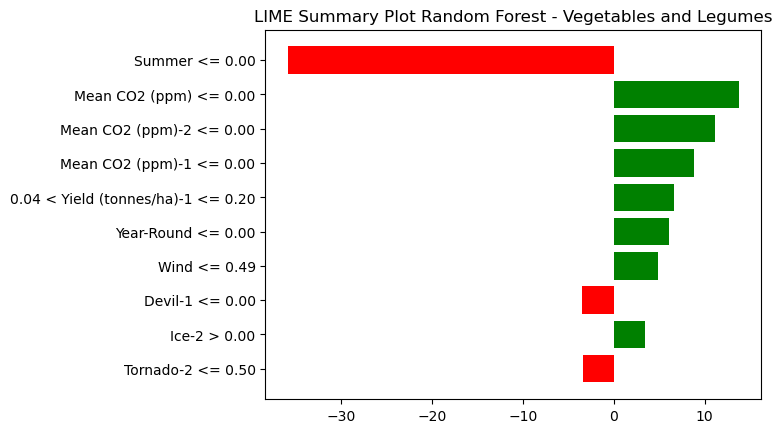

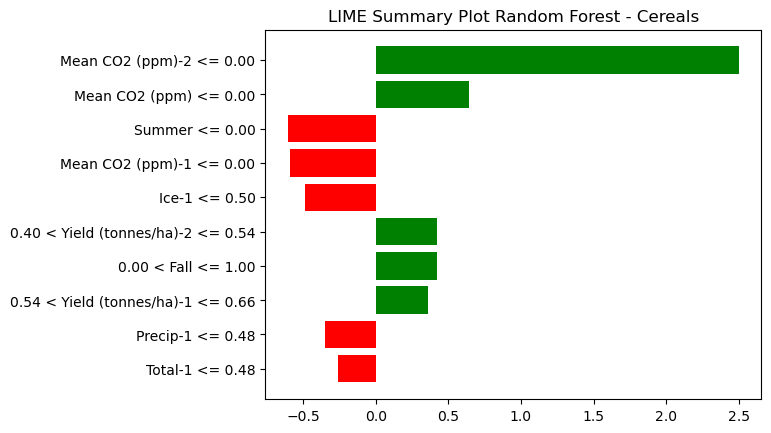

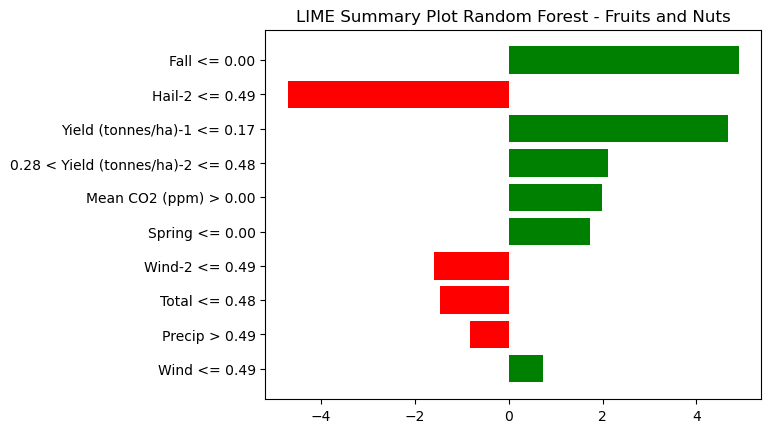

In [26]:
scaler = MinMaxScaler()
for cat in categories:
   crop_df = main_df[main_df['Category'] == cat]
   encoded_df = pd.get_dummies(crop_df[["Season"]], prefix='', prefix_sep='')
   encoded_df = encoded_df.drop(encoded_df.columns[-2], axis=1)

   y = crop_df[['Yield (tonnes/ha)']]
   x = crop_df.drop(['Yield (tonnes/ha)', "Item", "Category", "Season"], axis=1)
   x = pd.concat([x, encoded_df], axis=1)

   mean = x.mean()
   std = x.std()
   lower_bound = mean - 2 * std
   upper_bound = mean + 2 * std
   x = x.clip(lower_bound, upper_bound, axis=1)

   x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
   #x = x.dropna()
   #y = y.dropna()
   
   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=42)
   regressor = GradientBoostingRegressor(n_estimators = 1000, random_state = 42, learning_rate=0.2)
   regressor.fit(x_train, y_train)
   
   #prediction of new value
   y_pred = regressor.predict(x_test)

   #lime implementation
   explainer = lime.lime_tabular.LimeTabularExplainer(np.array(x_train),
                  feature_names=x_test.columns, 
                  class_names=['Yield(tonnes/ha)'], mode='regression')
   exp = explainer.explain_instance(x_test.iloc[0], 
   regressor.predict, num_features=10)
   exp_list = [(feat, abs(coeff)) for feat, coeff in exp.as_list()] # add absolute value of coefficients
   exp_list.sort(key=lambda x: x[1], reverse=True)
   exp.as_pyplot_figure()
   plt.title("LIME Summary Plot Random Forest - " + cat)
   display(pd.DataFrame(exp.as_list(),  columns=['Features ' + cat, 'Coeffcients - ' + cat]))
